# Import Modules

In [1]:
#Import Modules

#PyTorch
import torch as torch
from torch import nn
from torch.utils.data import DataLoader
import time 


import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import random
from typing import Iterable, Callable


#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

#Import tqdm for a cool progress bar
# from tqdm.auto import tqdm
from tqdm.notebook import tqdm

# Measure time
from timeit import default_timer as timer

print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"SciPy Version: {scipy.__version__}")

PyTorch Version: 2.5.1
Numpy Version: 1.26.4
Pandas Version: 2.2.3
Matplotlib Version: 3.10.0
SciPy Version: 1.15.1


# Install For Computational Graph Visualization

In [2]:
#Install For Computational Graph Visualization
# !pip install torchviz

# Setup device agnostic code

In [40]:
#Setup device agnostic code
import os
print(f"GPU Avalaibility: {torch.cuda.is_available()}")
if torch.cuda.is_available():
  device = "cuda"
  import torch.backends.cudnn as cudnn
  #Ensure deterministic behaviour if running in GPU
  '''
  Reproducibility: These settings are particularly useful when you need to ensure that results are
  reproducible across different runs, which is important for debugging and verifying that changes in
  your code or model have the desired effect
  '''
  cudnn.deterministic = True
  cudnn.benchmark = False
  !nvidia-smi
else:
   device = "cpu"
   print(f"Number of cores: {os.cpu_count()}")
print(f"Device: {device}")

GPU Avalaibility: True
Thu Feb 13 16:28:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        Off |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P3              8W /   30W |     625MiB /   4096MiB |     27%      Default |
|                                         |                        |                  N/A |
+------------------------

### evoLved sIgn mOmeNtum (LION) (2024)

In [6]:
#evoLved sIgn mOmeNtum (LION) (2024)
from typing import Tuple, Callable


"""
https://github.com/google/automl/blob/master/lion/lion_pytorch.py
https://github.com/lucidrains/lion-pytorch/tree/main
"""

# functions

def exists(val):
    return val is not None

# update functions

def update_fn(p, grad, exp_avg, lr, wd, beta1, beta2):
    # stepweight decay

    p.data.mul_(1. - lr * wd)

    # weight update

    update = exp_avg.clone().mul_(beta1).add(grad, alpha = 1. - beta1).sign_()
    p.add_(update, alpha = -lr)

    # decay the momentum running average coefficient

    exp_avg.mul_(beta2).add_(grad, alpha = 1. - beta2)

# class

class Lion(torch.optim.Optimizer):
    def __init__(
        self,
        params,
        lr: float = 1e-4,
        betas: Tuple[float, float] = (0.9, 0.99),
        weight_decay: float = 0.0,
        use_triton: bool = False,
        decoupled_weight_decay: bool = False,
    ):
        assert lr > 0.
        assert all([0. <= beta <= 1. for beta in betas])

        self._init_lr = lr
        self.decoupled_wd = decoupled_weight_decay

        defaults = dict(
            lr = lr,
            betas = betas,
            weight_decay = weight_decay
        )

        super().__init__(params, defaults)

        self.update_fn = update_fn

        if use_triton:
            from lion_pytorch.triton import update_fn as triton_update_fn
            self.update_fn = triton_update_fn

    @torch.no_grad()
    def step(
        self,
        closure: Callable | None = None
    ):

        loss = None
        if exists(closure):
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in filter(lambda p: exists(p.grad), group['params']):

                grad, lr, wd, beta1, beta2, state, decoupled_wd, init_lr = p.grad, group['lr'], group['weight_decay'], *group['betas'], self.state[p], self.decoupled_wd, self._init_lr

                # maybe decoupled weight decay

                if decoupled_wd:
                    wd /= init_lr

                # init state - exponential moving average of gradient values

                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']

                self.update_fn(
                    p,
                    grad,
                    exp_avg,
                    lr,
                    wd,
                    beta1,
                    beta2
                )

        return loss

### Muon

In [10]:
import os
import torch
import torch.distributed as dist

# @torch.compile
def zeropower_via_newtonschulz5(G, steps):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    if G.size(0) > G.size(1):
        X = X.T

    # Ensure spectral norm is at most 1
    X = X / (X.norm() + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A # adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X
    
    if G.size(0) > G.size(1):
        X = X.T
    return X

class Muon(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. To efficiently orthogonalize each update, we use a Newton-Schulz iteration, which has
    the advantage that it can be stably run in bfloat16 on the GPU.

    Some warnings:
    - We believe this optimizer is unlikely to work well for training with small batch size.
    - We believe it may not work well for finetuning pretrained models, but we haven't tested this.

    Arguments:
        muon_params: The parameters to be optimized by Muon.
        lr: The learning rate. The updates will have spectral norm of `lr`. (0.02 is a good default)
        momentum: The momentum used by the internal SGD. (0.95 is a good default)
        nesterov: Whether to use Nesterov-style momentum in the internal SGD. (recommended)
        ns_steps: The number of Newton-Schulz iterations to run. (6 is probably always enough)
        adamw_params: The parameters to be optimized by AdamW. Any parameters in `muon_params` which are
        {0, 1}-D or are detected as being the embed or lm_head will be optimized by AdamW as well.
        adamw_lr: The learning rate for the internal AdamW.
        adamw_betas: The betas for the internal AdamW.
        adamw_eps: The epsilon for the internal AdamW.
        adamw_wd: The weight decay for the internal AdamW.
    """
    def __init__(self, muon_params, lr=0.02, momentum=0.95, nesterov=True, ns_steps=6,
                 adamw_params=None, adamw_lr=3e-4, adamw_betas=(0.95, 0.95), adamw_eps=1e-8, adamw_wd=0):

        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov, ns_steps=ns_steps,
                        adamw_lr_ratio=adamw_lr/lr, adamw_betas=adamw_betas,
                        adamw_eps=adamw_eps, adamw_wd=adamw_wd)

        params = list(muon_params)
        adamw_params = list(adamw_params) if adamw_params is not None else []
        params.extend(adamw_params)
        super().__init__(params, defaults)

        # Sort parameters into those for which we will use Muon, and those for which we will not
        for p in muon_params:
            # Use Muon for every parameter in muon_params which is >= 2D and doesn't look like an embedding or head layer
            if p.ndim >= 2 and p.size(0) < 10000:
                self.state[p]['use_muon'] = True
            else:
                self.state[p]['use_muon'] = False
        for p in adamw_params:
            # Do not use Muon for parameters in adamw_params
            self.state[p]['use_muon'] = False

        if 'WORLD_SIZE' in os.environ:
            self.world_size = int(os.environ['WORLD_SIZE'])
            self.rank = int(os.environ['RANK'])
        else:
            self.world_size = 1
            self.rank = 0

    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:

            ############################
            #           Muon           #
            ############################

            params = [p for p in group['params'] if self.state[p]['use_muon']]
            lr = group['lr']
            momentum = group['momentum']

            # generate weight updates in distributed fashion
            total_params = sum(p.numel() for p in params)
            # updates_flat = torch.zeros(total_params, device='cuda', dtype=torch.bfloat16)
            updates_flat = torch.zeros(total_params, device='cpu', dtype=torch.bfloat16)
            curr_idx = 0
            for i, p in enumerate(params):
                # luckily this will perfectly distribute a transformer with multiple of 4 layers to 8 GPUs
                if i % self.world_size == self.rank:
                    g = p.grad
                    if g is None:
                        continue
                    if g.ndim > 2:
                        g = g.view(g.size(0), -1)
                    assert g is not None
                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        state['momentum_buffer'] = torch.zeros_like(g)
                    buf = state['momentum_buffer']
                    buf.mul_(momentum).add_(g)
                    if group['nesterov']:
                        g = g.add(buf, alpha=momentum)
                    else:
                        g = buf
                    g = zeropower_via_newtonschulz5(g, steps=group['ns_steps'])
                    g *= max(1, g.size(0)/g.size(1))**0.5
                    updates_flat[curr_idx:curr_idx+p.numel()] = g.flatten()
                curr_idx += p.numel()

            # sync updates across devices. we are not memory-constrained so can do this simple deserialization
            if self.world_size > 1:
                dist.all_reduce(updates_flat, op=dist.ReduceOp.SUM)

            # deserialize and apply updates
            curr_idx = 0
            for p in params:
                g = updates_flat[curr_idx:curr_idx+p.numel()].view_as(p.data).type_as(p.data)
                p.data.add_(g, alpha=-lr)
                curr_idx += p.numel()

            ############################
            #       AdamW backup       #
            ############################

            params = [p for p in group['params'] if not self.state[p]['use_muon']]
            lr = group['adamw_lr_ratio'] * group['lr'] # in order for lr schedule to work
            beta1, beta2 = group['adamw_betas']
            eps = group['adamw_eps']
            weight_decay = group['adamw_wd']

            for p in params:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if 'step' not in state:
                    state['step'] = 0
                    state['moment1'] = torch.zeros_like(g)
                    state['moment2'] = torch.zeros_like(g)
                state['step'] += 1
                step = state['step']
                buf1 = state['moment1']
                buf2 = state['moment2']
                buf1.lerp_(g, 1-beta1)
                buf2.lerp_(g.square(), 1-beta2)

                g = buf1 / (eps + buf2.sqrt())

                bias_correction1 = 1 - beta1**step
                bias_correction2 = 1 - beta2**step
                scale = bias_correction1 / bias_correction2**0.5
                p.data.mul_(1 - lr * weight_decay)
                p.data.add_(g, alpha=-lr/scale)

        return loss

## Build a Training Loop

### Functionizing training and testing loops Part 1

In [11]:
#Functionizing training and testing loops Part 1

def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) #from logits -> prediction labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.4f}%")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test Accuracy {test_acc:5f}%")
    return test_loss, test_acc

## Creating a Model : Residual Neural Network ResNet18 

### Importing the data

#### Split Dataset

In [4]:
#Split Dataset
import os
import random
import shutil


def split_dataset(original_folder, train_folder, test_folder, split_ratio=0.8):
    # Create the train and test folders if they don't exist
  if not os.path.exists(train_folder):
    os.makedirs(train_folder)
  if not os.path.exists(test_folder):
    os.makedirs(test_folder)

  categories = [d for d in os.listdir(original_folder) if os.path.isdir(os.path.join(original_folder, d))]

  for category in categories:
    category_path = os.path.join(original_folder, category)
    images = [f for f in os.listdir(category_path) if f.lower().endswith('.jpg')]
    images = os.listdir(category_path)
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]

    train_category_path = os.path.join(train_folder, category)
    test_category_path = os.path.join(test_folder, category)
    if not os.path.exists(train_category_path):
      os.makedirs(train_category_path)
    if not os.path.exists(test_category_path):
      os.makedirs(test_category_path)

    for image in train_images:
      shutil.copy(os.path.join(category_path, image), train_category_path)
    for image in test_images:
      shutil.copy(os.path.join(category_path, image), test_category_path)

original_folder = "FSL"
train_folder = "FSL_new/Training"
test_folder = "FSL_new/Testing"

split_dataset(original_folder, train_folder, test_folder)

#### Walkthrough Inside Directory

In [7]:
#Walkthrough inside the directory
import os
path0 = "FSL"
path1 = "FSL_new/Training"
path2 = "FSL_new/Testing"

def count_jpgs(path):
  jpg_count = 0
  for item in os.listdir(path):
    full_path = os.path.join(path, item)
    if os.path.isfile(full_path) and item.lower().endswith('.jpg'):
      jpg_count += 1
    elif os.path.isdir(full_path):
      jpg_count += count_jpgs(full_path)
  return jpg_count


def look_at_dir(path):
  for dirpath, dirnames, filenames in os.walk(path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

count_total_original = count_jpgs(path0)
count_total1 = count_jpgs(path1)
count_total2 = count_jpgs(path2)
print(f"Total number of image files (jpg format) original folder {count_total_original}")
print(f"Total number of image files (jpg format) Training {count_total1}")
print(f"Total number of image files (jpg format) Testing {count_total2}")

print(f"                                                                  ")

print(f"Inside the Training Folder")
print(f"{look_at_dir(path1)}")
print(f"                                                                  ")
print(f"Inside the Testing Folder")
print(f"{look_at_dir(path2)}")
print(f"Inside the Original Folder")
print(f"{look_at_dir(path0)}")

Total number of image files (jpg format) original folder 11700
Total number of image files (jpg format) Training 9360
Total number of image files (jpg format) Testing 2340
                                                                  
Inside the Training Folder
There are 26 directories and 0 images in 'FSL_new/Training'.
There are 0 directories and 360 images in 'FSL_new/Training/A'.
There are 0 directories and 360 images in 'FSL_new/Training/B'.
There are 0 directories and 360 images in 'FSL_new/Training/C'.
There are 0 directories and 360 images in 'FSL_new/Training/D'.
There are 0 directories and 360 images in 'FSL_new/Training/E'.
There are 0 directories and 360 images in 'FSL_new/Training/F'.
There are 0 directories and 360 images in 'FSL_new/Training/G'.
There are 0 directories and 360 images in 'FSL_new/Training/H'.
There are 0 directories and 360 images in 'FSL_new/Training/I'.
There are 0 directories and 360 images in 'FSL_new/Training/J'.
There are 0 directories and 360 i

Image class: J
Image height: 171
Image width: 172


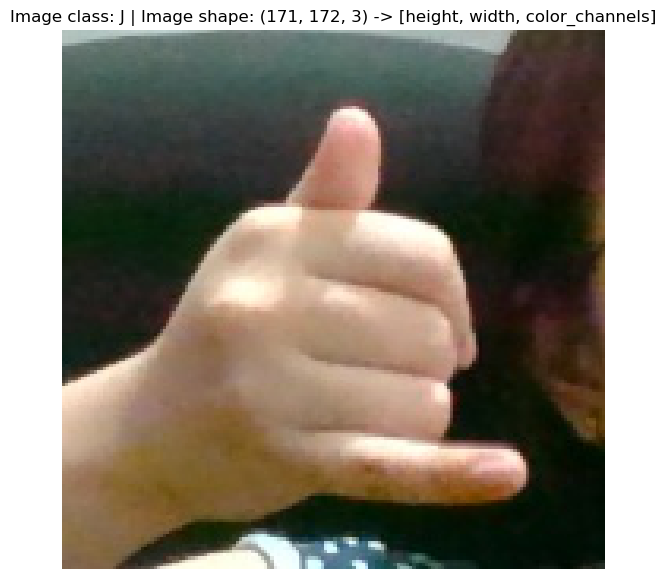

In [12]:
import os
from pathlib import Path
import random
from PIL import Image

# Set seed
# random.seed(45)
path1 = Path(path1)

# 1. Get all image paths (use ** to search recursively)
image_path_list = list(path1.glob("**/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path).convert("RGB")

# 5. Print metadata
# print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array, cmap="gray")
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

#### Dataprocessing with torchvision, DataLoader

In [36]:
#Dataprocessing with torchvision, DataLoader
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
torch.manual_seed(42)
torch.cuda.manual_seed(42)

transform_data = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root=path1, transform=transform_data, target_transform=None);
test_data = datasets.ImageFolder(root=path2, transform=transform_data);
print(f"=============================================================================="*100)
print(f"Print Some Infomration:")
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

print(f"=============================================================================="*100)
print(f"Training Data information below:")
print(f"Classes: {train_data.classes}")
print(f"Print the Number of Classes: {len(train_data.classes)}")
print(f"Print Classes and indices: {train_data.class_to_idx}")
print(f"=============================================================================="*100)
##Data Loader
batchsize = 64
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batchsize,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batchsize,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader1 = DataLoader(dataset=train_data,
                               batch_size=500,
                               num_workers=os.cpu_count(),
                               shuffle=True)

test_dataloader1 = DataLoader(dataset=test_data,
                              batch_size=500,
                              num_workers=os.cpu_count(),
                              shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train_dataloader}\nTest dataloader: {test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")
print(f"=============================================================================="*100)

Print Some Infomration:
Train data:
Dataset ImageFolder
    Number of datapoints: 9360
    Root location: FSL_new/Training
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2340
    Root location: FSL_new/Testing
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Training Data information below:
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Print the Number of Classes: 26
Print Classes and indices: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N':

#### Visualize the images from Baybayin dataset

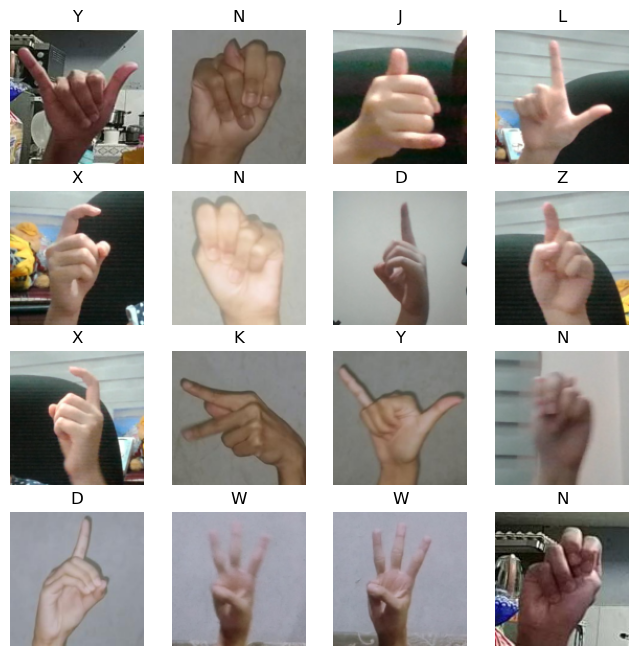

In [37]:
# Visualize the images from Baybayin dataset
# seed = 42
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
fig = plt.figure(figsize=(8, 8))
rows, columns = 4, 4
for i in range(1, rows * columns + 1):
    idx = torch.randint(0, len(test_data), size=[1]).item()
    img, label = test_data[idx][0], test_data[idx][1]
    img = img.permute(1,2,0)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.title(test_data.classes[label])
    plt.grid(True)
    plt.axis(False);

plt.axis(False)
# plt.savefig("Visualize_FSL_Dataset.png", dpi=600, bbox_inches="tight") ###-->Uncomment to save the image
plt.show()

### Model and Training

#### Modified ResNet34 Architecture

In [80]:
class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet, self).__init__()
        self.input = 32
        self.conv1 = nn.Conv2d(input_shape, 32, kernel_size=(5,5), stride=(2,2), padding=(2,2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=32, stride=(1,1))
        self.layer2 = self.make_layer(block,layers[1], output=64, stride=(2,2))
        self.layer3 = self.make_layer(block,layers[2], output=128, stride=(2,2))
        self.layer4 = self.make_layer(block,layers[3], output=256, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(256*block.expansion, output_shape)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for i in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)


seed = 25
torch.manual_seed(25)
fsl_model = ResNet(Block, [3,4,6,3], input_shape=3, output_shape=26).to(device)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), paddin

In [81]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))
print(f"{img_batch.shape}")
print(f"{label_batch.shape}")

tensor1 = torch.randn(size=(3,128,128))
print(tensor1.shape)

tensor1 = torch.randn(size=(3, 128, 128)).to(device)  # Single image (C, H, W)
print(tensor1.shape)  # Should print torch.Size([3, 128, 128])

output = fsl_model(tensor1.unsqueeze(dim=0)).to(device)  # Add batch dimension
print(output)

torch.Size([64, 3, 128, 128])
torch.Size([64])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
tensor([[ 0.3177, -0.1259, -0.2483,  0.4535,  0.2242,  0.0898, -0.4986,  0.5079,
         -0.3034, -0.1862,  0.4616,  0.3607,  0.2509, -0.0105,  0.1103, -0.2102,
          0.1073, -0.7111,  0.5277,  1.5441,  0.2248, -0.4212,  0.2085,  0.0156,
         -0.2062, -0.4376]], device='cuda:0', grad_fn=<AddmmBackward0>)


### Training Loops for the FSL ResNet Model

#### Setup Loss Functions, Accuracy function

In [82]:
#Setup Loss Functions, Accuracy function
loss_fn = nn.CrossEntropyLoss()

#Define Accuracy Metric
def calculate_accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct / len(y_pred)) * 100
  return accuracy

def compute_initial_loss(dataloader, model, loss_fn, calculate_accuracy, device, seed: int = 169):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    model.eval()  # Set the model to evaluation mode
    initial_loss = 0.0
    initial_acc = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            initial_loss += loss.item()
            initial_acc += calculate_accuracy(y_true=y, y_pred=y_pred.argmax(dim=1))

    # initial_loss /= len(dataloader)
    # initial_acc /= len(dataloader)
    return initial_loss / len(dataloader), initial_acc / len(dataloader)

model_init = ResNet(Block, [3,4,6,3], input_shape=3, output_shape=len(train_data.classes)).to(device)

initial_train_loss, initial_train_accu = compute_initial_loss(train_dataloader, model_init, loss_fn, calculate_accuracy, device)
initial_test_loss, initial_test_accu = compute_initial_loss(test_dataloader, model_init, loss_fn, calculate_accuracy,device)

print(f"Initial Train Loss: {initial_train_loss}")
print(f"Initial Test Loss: {initial_test_loss}")
print(f"Initial Train Accuracy: {initial_test_accu}")
print(f"Initial Test Accuracy: {initial_test_accu}")

Initial Train Loss: 3.2589078095494486
Initial Test Loss: 3.258723278303404
Initial Train Accuracy: 3.800675675675676
Initial Test Accuracy: 3.800675675675676


#### Some initial parameters

In [83]:
num_of_epochs = 50
num_loss_steps = 5
seed_number = 42
learning_rate = 0.001

#### Optimization Loops

##### LION

In [ ]:
#Optimizer: LION

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

model_LION = ResNet(Block, [3,4,6,3], input_shape=3, output_shape=len(train_data.classes)).to(device)
model_LION.to(device)
optimizer_LION = Lion(params=model_LION.parameters(), 
                      lr=learning_rate, 
                      betas=(0.9, 0.99), 
                      weight_decay=1e-2)

results1 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

epoch = num_of_epochs
loss_steps = num_loss_steps 
start_lion = time.perf_counter()
for epoch in tqdm(range(epoch)):
  if epoch % loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss1, train_accu1 = train(data_loader = train_dataloader,
                                    model = model_LION,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer_LION,
                                    calculate_accuracy = calculate_accuracy,
                                    device = device,
                                    loss_steps = loss_steps,
                                    seed = seed);

  test_loss1, test_accu1 = test(data_loader = test_dataloader,
                                     model = model_LION,
                                     loss_fn = loss_fn,
                                     calculate_accuracy = calculate_accuracy,
                                     device = device,
                                     loss_steps = loss_steps,
                                     seed=seed)

  results1["train_loss"].append(train_loss1)
  results1["train_accu"].append(train_accu1)
  results1["test_loss"].append(test_loss1)
  results1["test_accu"].append(test_accu1)
end_lion = time.perf_counter()
total_time_lion = end_lion - start_lion
print(f"Total Runtime: {total_time_lion}")

#####  Muon

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

model_Muon = ResNet(Block, [3,4,6,2], input_shape=3, output_shape=len(train_data.classes)).to(device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_Muon.to(device)

# Find ≥2D parameters in the body of the network -- these will be optimized by Muon
muon_params = [p for p in model_Muon.parameters() if p.ndim >= 2]

# Find everything else -- these will be optimized by AdamW
adamw_params = [p for p in model_Muon.parameters() if p.ndim < 2]
adamw_params.extend(model_Muon.classifier.parameters())

optimizer15_bby = Muon(muon_params, 
                       lr=learning_rate, 
                       momentum=0.9, 
                       nesterov=True, 
                       ns_steps=20,
                       adamw_params=adamw_params, 
                       adamw_lr=5e-4, 
                       adamw_betas=(0.90, 0.999), 
                       adamw_wd=0.01)

results2 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

epoch = num_of_epochs
loss_steps = num_loss_steps
start_muon = time.perf_counter() 
for epoch in tqdm(range(epoch)):
  if epoch % loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss2, train_accu2 = train(data_loader = train_dataloader1,
                                     model = model_Muon,
                                     loss_fn = loss_fn,
                                     optimizer = optimizer15_bby,
                                     calculate_accuracy = calculate_accuracy,
                                     loss_steps = loss_steps,
                                     seed = seed);

  test_loss2, test_accu2 = test(data_loader = test_dataloader1,
                                  model = model_Muon,
                                  loss_fn = loss_fn,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = loss_steps,
                                  seed = seed)

  results2["train_loss"].append(train_loss15)
  results2["train_accu"].append(train_accu15)
  results2["test_loss"].append(test_loss15)
  results2["test_accu"].append(test_accu15)
end_muon = time.perf_counter()

total_time_muon = end_muon - start_muon

#### Plot Loss Curves

In [ ]:

results1["train_loss"].insert(0, initial_train_loss)
# results13_bby["train_loss"].insert(0, initial_train_loss)
# results14_bby["train_loss"].insert(0, initial_train_loss)
# results15_bby["train_loss"].insert(0, initial_train_loss)


# results13_bby["test_loss"].insert(0, initial_test_loss)
# results14_bby["test_loss"].insert(0, initial_test_loss)
# results15_bby["test_loss"].insert(0, initial_train_loss)

###### Training Loss for FSL ResNet Model

In [ ]:
#Training Loss for Baybayin Dataset
plt.figure(figsize=(12,8))
# plt.plot(results1["train_loss"], linewidth=2.0, color="#009503",label="Lion (2023)")
plt.plot(results1["train_loss"], linewidth=2.0,color="#AA0000",label="Lion (2023)")
plt.plot(results2["train_loss"], linestyle="-.", linewidth=3.0, color="#003300", label="Muon (2024)")
plt.legend(loc="upper right", fontsize=16)
plt.grid(True)
# xticks = np.arange(0, 56, 2)
# plt.xticks(xticks, fontsize=16)
# plt.xlim(0,50)
xticks = np.arange(0, 11, 1)
plt.xticks(xticks, fontsize=16)
plt.xlim(0,10)
plt.ylim(0,3)
yticks = np.arange(0,3.5,0.5)
plt.yticks(fontsize=16)
plt.title("Training Loss (Baybayin Dataset)", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
# plt.savefig("bby_trainloss.png", dpi=300, bbox_inches="tight")
plt.show()

##### Training Loss (Semilog plot)

In [ ]:
plt.figure(figsize=(12, 8))
plt.semilogy(results1["train_loss"], linestyle="-", linewidth=3.0, color="#AA0000", label="Lion (2023)")
plt.semilogy(results2["train_loss"], linestyle="-.", linewidth=3.0, color="#003300", label="Muon (2024)")

plt.legend(loc="upper right", fontsize=16)
plt.grid(True)
plt.legend(loc="upper right", fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

xticks = np.arange(0, 60, 5)
plt.xticks(xticks, fontsize=16)
plt.xlim(0, 50)

# Adjust y-axis to fit the semilogy scale
yticks = [1e-2, 1e-1, 0.02, 0.03, 0.04,1e0]  
plt.yticks(yticks, fontsize=16)

plt.title("Training Loss (FSL ResNet Model)", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

# plt.savefig(fsl_trainloss_semilogy.png", dpi=300, bbox_inches="tight")
plt.show()

##### Test Loss for FSL ResNet Model

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(results1["test_loss"], linewidth=2.0,color="#009503",label="Lion (2023)")
# plt.plot(results1["test_loss"], linewidth=2.0,color="#AA0000",label="Lion (2023)")
plt.plot(results2["test_loss"], linestyle="-.", linewidth=3.0, color="#003300", label="Muon (2024)")
plt.legend(loc="upper right", fontsize=16)
plt.grid(True)
xticks = np.arange(0, 56, 2)
plt.xticks(xticks, fontsize=16)
plt.xlim(0,50)
plt.ylim(0,3)
yticks = np.arange(0,3.5,0.5)
plt.yticks(yticks, fontsize=16)
plt.title("Test Loss (FSL ResNet Model)", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
# plt.savefig("fsl_testloss.png", dpi=300, bbox_inches="tight")
plt.show()

##### Test Loss Semilsog Plot Part 1

In [ ]:
import matplotlib.ticker as ticker
# Test Loss for FSL ResNet Model with semilogy
plt.figure(figsize=(12, 8))

plt.semilogy(results1["test_loss"], linestyle="-", linewidth=3.0, color="#AA0000", label="Lion (2023)")
plt.semilogy(results2["test_loss"], linestyle="-.", linewidth=3.0, color="#003300", label="Muon (2024)")
plt.legend(loc="upper right", fontsize=16)
plt.grid(True)
plt.legend(loc="upper right", fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

xticks = np.arange(0, 60, 5)
plt.xticks(xticks, fontsize=16)
plt.xlim(0, 50)

# Adjust y-axis to fit the semilogy scale
# yticks = [0.1, 0.2, 0.5, 1, 2, 3]
# yticks = np.arange(0.01, 2, 0.5)
# yticks = [0.09, 0.1, 0.15, 0.1]
# yticks = np.logspace(-1, 0.1, 10)
# plt.yticks(yticks, fontsize=16)

yticks = [1e-1,1e0,1,2]  
yticks_minor = [2e-2, 5e-2, 2e-1, 5e-1, 2e0] 

plt.yticks(yticks, fontsize=16)

plt.title("Test Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

# plt.savefig("fsl_testloss_semilogy.png", dpi=300, bbox_inches="tight")
plt.show()

#### Plot Accuracy Curves

In [ ]:
results1["train_accu"].insert(0, initial_train_accu)
results2["train_accu"].insert(0, initial_train_accu)


results1["test_accu"].insert(0, initial_test_accu)
results2["test_accu"].insert(0, initial_test_accu)

##### Training Accuracy

In [ ]:
#Training Accuracy
plt.figure(figsize=(12,7))
plt.plot(results1["train_accu"], color="#009503",label="Lion (2024)")
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
xticks = np.arange(0, 56, 2)
plt.xticks(xticks, fontsize=14)
plt.xlim(0,50)
plt.ylim(0,100)
yticks = np.arange(0,110,10)
plt.yticks(yticks, fontsize=14)
plt.title("Training Accuracy (Baybayin Dataset)", fontsize=14)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
# plt.savefig(fsl_trainaccu.png", dpi=300, bbox_inches="tight")
plt.show()

##### Test Accuracy

In [ ]:
#Test Accuracy
plt.figure(figsize=(12,7))
# plt.xscale("log")
plt.plot(results1["test_accu"], linestyle="-", linewidth=3.0, color="#AA0000", label="Lion (2023)")
plt.plot(results2["test_accu"], linestyle="-.", linewidth=3.0, color="#003300", label="Muon (2024)")
plt.legend(loc="lower right", fontsize=14, framealpha=0.4)
plt.grid(True)
xticks = np.arange(0, 56, 2)
plt.xticks(xticks, fontsize=16)
plt.xlim(0,50)
plt.ylim(0,100)
yticks = np.arange(0,110,10)
plt.yticks(yticks, fontsize=16)
# plt.title("Test Accuracy (Baybayin Dataset)", fontsize=14)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
# plt.savefig("bby_testaccu.png", dpi=300, bbox_inches="tight")
plt.show()

#### Time Taken for each optimizer

In [ ]:
list_optimizers = ["LION", "Muon"]
list_opt_time = [total_time_lion, total_time_muon]
for i in range(len(list_optimizers)):
    print(f"{list_optimizers[i]} : {list_opt_time[i] / 60:.3f} minutes")

### Evaluation Section

##### Visualize Predicted vs Truth

In [ ]:
import random

def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = device
    ):
  pred_probs = [];
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)


random.seed(23)
test_samples = []; test_labels = [];
for sample, label in random.sample(list(test_data), k=17):
  test_samples.append(sample)
  test_labels.append(label)

test_labels_tensor = torch.tensor(test_labels)

def predictions_accu(test_labels, pred_classes):
  test_labels_tensor = torch.tensor(test_labels)
  accu = (torch.sum(test_labels_tensor == pred_classes) / len(test_labels)).item() * 100 
  return accu


pred_probs1 = make_predictions(model = model_LION,
                              data = test_samples)
pred_classes1 = pred_probs1.argmax(dim=1)
fsl_predicted_accu = predictions_accu(test_labels, pred_classes1)


print(f"Predicted by the trained Model")
print(f"Predicted Labels: {pred_classes1}")
print(f"Actual Labels: {test_labels}")
print(f"Partial Accuracy {fsl_predicted_accu: .2f}% out of a few samples")

#### Visualize Actual versus Predicted

In [ ]:
plt.figure(figsize=(12,8))
rows = 4
cols = 4
for i, sample in enumerate(test_samples):
  plt.subplot(rows, cols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  #Find the prediction labels
  pred_label = train_data.classes[pred_classes1[i]]
  #Get the true labels
  truth_label = test_data.classes[test_labels[i]]

  #Create the title text of the plot
  title_text = f"Predicted: {pred_label} | Actual {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, color="#007700")
  else:
    plt.title(title_text, color="red")
  plt.grid(True)
  plt.axis(False)
  # plt.savefig("bby_vispred.png", dpi=600, bbox_inches="tight")

#### Install torchmetrics and Import mlxtend upgraded version

In [84]:
try:
  import torchmetrics, mlxtend
  print(f"mlx version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlx version: {mlxtend.__version__}")


#Import mlxtend upgraded version
import mlxtend
assert int(mlxtend.__version__.split(".")[1]) >= 19

mlx version: 0.23.4


#### F1, Precision, and Recall Scores function from scikit learn

In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score
def calculate_metric(y_true, y_pred, average="weighted"): ##--> Choose 'micro', 'macro', or 'weighted'
    # Convert logits to predicted class labels if necessary
    if y_pred.dim() > 1:
        y_pred = torch.argmax(y_pred, dim=1)

    # Move to CPU and convert to numpy arrays if necessary
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average=average)  
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    
    return f1, precision, recall

#### Make predictions with FSL ResNet Model

In [ ]:
from torchmetrics.classification import ConfusionMatrix
from torchmetrics.functional import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def infer(data_loader:torch.utils.data.DataLoader,
           model:torch.nn.Module,
           test_data):
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Send the data to the proper target device
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_logit = model(X)
            # Turn predictions into class labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())

    # Concatenate list of predictions into a tensor
    y_preds = torch.cat(y_preds)  # This line ensures y_preds is a tensor

    # Ensure test_data.targets is a tensor
    test_targets_tensor = torch.tensor(test_data.targets) if not isinstance(test_data.targets, torch.Tensor) else test_data.targets
    return test_targets_tensor, y_preds

test_targets1, y_preds1 = infer(test_dataloader, model_LION, test_data)

def create_confusion_matrix(y_true, y_pred, class_names, num_classes=None, figsize=(19, 10)):

    if num_classes is None:
        num_classes = len(class_names)
    
    # Create confusion matrix instance
    confmat = ConfusionMatrix(num_classes=num_classes, task="multiclass")
    confmat_tensor = confmat(preds=y_pred, target=y_true)
    
    # Plot confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=figsize
    )
    plt.show()
    
    return confmat_tensor

create_confusion_matrix(test_targets1, y_preds1, class_names=train_data.classes)
f1_score1, precision_score1, recall_score1 = calculate_metric(test_targets1.cpu(), y_preds1)
print(f"Print F1 score: {f1_score1}")
print(f"Precision Score: {precision_score1}")
print(f"Recall Score: {recall_score1}")


#### Metric Scores



In [ ]:
test_targets2, y_preds2 = infer(test_dataloader, model_Muon, test_data)
f1_score2, precision_score2, recall_score2 = calculate_metric(test_targets2.cpu(), y_preds2)
print(f"Muon F1: {f1_score2} | Precision: {precision_score2} | Recall {recall_score2}")

In [ ]:
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task="multiclass")
confmat_tensor = confmat(preds=y_preds2, target=test_targets1)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=train_data.classes,
    figsize=(19, 10)
)



# Saving the Model

In [ ]:
from pathlib import Path

# Create model save path
File = "Trained_FSL_ResNet.pth"

# Save the model state dict
# print(f"Saving model to: {File}")
# torch.save(obj=model2_PAGMA.state_dict(), # only saving the state_dict() only saves the learned parameters
#            f=File)

# print(f"Saving model to: {File}")
# torch.save(obj=model2_PAGMA,
#            f=File)

In [ ]:
# model_scripted = torch.jit.script(model2_PAGMA) # Export to TorchScript
# model_scripted.save('ResNet_trained2.pt') # Save